(c) 2020, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# import simulated data
data_simulated = pd.read_csv('./ECG_data/SimulatedECG.txt', sep=" ", header=1)
data_simulated.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [4]:
# import measured data
data_measured = pd.read_csv('./ECG_data/MeasuredECG.txt', sep=" ", header=1)
data_measured.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


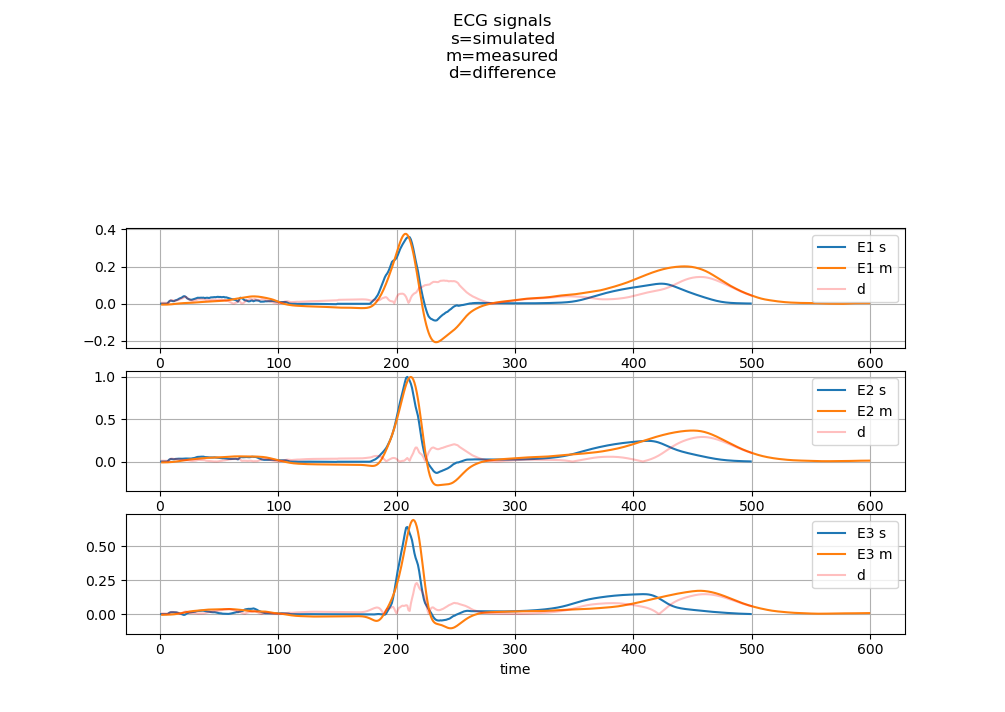

In [264]:
%matplotlib notebook
#fig = plt.figure(figsize=(8.5, 10.5))
fig = plt.figure()
fig.suptitle('ECG signals\ns=simulated\nm=measured\nd=difference')

header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
#l = len(header)
l = 4
for i in range(l):
    if header[i] == 'time': continue

    fig.add_subplot(l, 1, i + 1)
    plt.plot(data_simulated['time'], data_simulated[header[i]], label=header[i] + ' s')
    plt.plot(data_measured['time'], data_measured[header[i]], label=header[i] + ' m')
    plt.plot(data_measured['time'], abs(data_simulated[header[i]] - data_measured[header[i]]), c='r', alpha=.25, label='d')
    plt.grid()
    plt.legend(loc='upper right')

plt.xlabel('time')
plt.show()

# Fit to nonlinear oscillators

The ECG time series $y$ shall be represented by a set of differential equations. We achieve that by fitting $y$ to functions $f$:

$$
\dot{y} = f_1(y, \dot{y})\\
\ddot{y} = f_2(y, \dot{y})
$$

From the initial time series $y$, $\dot{y}$ and $\ddot{y}$ can be calculated numerically. Using a least square fit, $f_1$ and $f_2$ can be derived. If the ansatz of the nonlinear oscillator is true, the first component, $f_1$ should be linear.

With $n$ dimensions. We want to find a function $f$ to fit the series depending on a vector $\vec{p}$. We choose $f(y_i,\dot{y}_i;\vec{p})=p_0\cdot y+p_1 \cdot \dot{y} + p_2 \cdot y^2 + p_3 \cdot y \cdot \dot{y} + p_4 \cdot \dot{y}^2$ where the dataset $\{y, \dot{y}\}$ is the one we want $f$ to be fitted to.

$$
\frac{1}{n} \sum_i^n(f(y_i,\dot{y}_i;\vec{p})-z_i)^2 = Min.
$$

Which is equivalent to:

$$
\frac{\partial}{\partial p_k}\sum_i^n(f(y_i,\dot{y}_i;\vec{p})-z_i)^2=\sum_i^n(f(y_i,\dot{y}_i;\vec{p})-z_i)\frac{\partial}{\partial p_k}f(y_i,\dot{y}_i;\vec{p})=0
$$

Which yields a system of equations. Written in $A\cdot p=b$:

$$
\begin{pmatrix}
\sum_i^n y_i^2 & \sum_i^n y_i \dot{y}_i & \sum_i^n y_i^3 & \sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i \dot{y}_i^2 \\
\sum_i^n y_i \dot{y}_i & \sum_i^n \dot{y}_i^2 & \sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i \dot{y}_i^2 & \sum_i^n \dot{y}_i^3 \\
\sum_i^n y_i^3 & \sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i^4 & \sum_i^n y_i^3 \dot{y}_i & \sum_i^n y_i^2 \dot{y}_i^2 \\
\sum_i^n y_i^2 \dot{y}_i & \sum_i^n y_i \dot{y}_i^2 & \sum_i^n y_i^3 \dot{y}_i & \sum_i^n y_i^2 \dot{y}_i^2 & \sum_i^n y_i \dot{y}_i^3 \\
\sum_i^n y_i \dot{y}_i^2 & \sum_i^n \dot{y}_i^3 & \sum_i^n y_i^2 \dot{y}_i^2 & \sum_i^n y_i \dot{y}_i^3 & \sum_i^n y_i \dot{y}_i^4 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
p_3 \\
p_4 \\
\end{pmatrix}
=
\begin{pmatrix}
\sum_i^n z_i y_i \\
\sum_i^n z_i \dot{y}_i \\
\sum_i^n z_i y_i^2 \\
\sum_i^n z_i y_i \dot{y}_i \\
\sum_i^n z_i \dot{y_i}^2 \\
\end{pmatrix}
$$

Solving for $\vec{p}$ yields:

$$
\vec{p} = A^{-1} \cdot b
$$

where $A^{-1}_{ij} = \frac{\alpha_{ij}}{|A|}$ and $\alpha_{ij}$ are the elements of the adjoint matrix $A_{ad}$.

Applying to ECG series using this snippet:

In [5]:
def solve_eqs_for_p(y, ydot, z, _):
    a = [[np.sum(y ** 2), np.sum(y * ydot), np.sum(y ** 3), np.sum(y ** 2 * ydot), np.sum(y * ydot ** 2), \
              np.sum(y ** 4), np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3)],
         [np.sum(y * ydot), np.sum(ydot ** 2), np.sum(y ** 2 * ydot), np.sum(y * ydot ** 2), np.sum(ydot ** 3), \
              np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3), np.sum(ydot ** 4)],
         [np.sum(y ** 3), np.sum(y ** 2 * ydot), np.sum(y ** 4), np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), \
              np.sum(y ** 5), np.sum(y ** 4 * ydot), np.sum(y ** 3 * ydot ** 2), np.sum(y ** 2 * ydot ** 3)],
         [np.sum(y ** 2 * ydot), np.sum(y * ydot ** 2), np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3), \
              np.sum(y ** 4 * ydot), np.sum(y ** 3 * ydot ** 2), np.sum(y ** 2 * ydot ** 3), np.sum(y * ydot ** 4)],
         [np.sum(y * ydot ** 2), np.sum(ydot ** 3), np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3), np.sum(y * ydot ** 4), \
              np.sum(y ** 3 * ydot ** 2), np.sum(y ** 2 * ydot ** 3), np.sum(y * ydot ** 4), np.sum(ydot ** 5)],
         [np.sum(y ** 4), np.sum(y ** 3 * ydot), np.sum(y ** 5), np.sum(y ** 4 * ydot), np.sum(y ** 3 * ydot ** 2), \
              np.sum(y ** 6), np.sum(y ** 5 * ydot), np.sum(y ** 4 * ydot ** 2), np.sum(y ** 3 * ydot ** 3)],
         [np.sum(y ** 3 * ydot), np.sum(y ** 2 * ydot ** 2), np.sum(y ** 4 * ydot), np.sum(y ** 3 * ydot ** 2), np.sum(y ** 2 * ydot ** 3), \
              np.sum(y ** 5 * ydot), np.sum(y ** 4 * ydot ** 2), np.sum(y ** 3 * ydot ** 3), np.sum(y ** 2 * ydot ** 4)],
         [np.sum(y ** 2 * ydot ** 2), np.sum(y * ydot ** 3), np.sum(y ** 3 * ydot ** 2), np.sum(y ** 2 * ydot ** 3), np.sum(y * ydot ** 4), \
              np.sum(y ** 4 * ydot ** 2), np.sum(y ** 3 * ydot ** 3), np.sum(y ** 2 * ydot ** 4), np.sum(y * ydot ** 5)],
         [np.sum(y * ydot ** 3), np.sum(ydot ** 4), np.sum(y ** 2 * ydot ** 3), np.sum(y * ydot ** 4), np.sum(ydot ** 5), \
              np.sum(y ** 3 * ydot ** 3), np.sum(y ** 2 * ydot ** 4), np.sum(y * ydot ** 5), np.sum(ydot ** 6)]
        ]
    b = [[np.sum(z * y)],
         [np.sum(z * ydot)],
         [np.sum(z * y ** 2)],
         [np.sum(z * y * ydot)],
         [np.sum(z * ydot ** 2)],
         [np.sum(z * y ** 3)],
         [np.sum(z * y ** 2 * ydot)],
         [np.sum(z * y * ydot ** 2)],
         [np.sum(z * ydot ** 3)]
        ]
    
    #print(np.array(a))
    #print(np.array(b))
    
    return np.linalg.solve(a, b)

In [14]:
def compute_2d_polynominal(grade):
    y_res = []
    ydot_res = []
    
    while grade > 0:
        o = compute_2d_polynominal_single_part(grade)
        y_res += o[0]
        ydot_res += o[1]
        
        grade -= 1

    return (y_res[::-1], ydot_res[::-1])

def compute_2d_polynominal_single_part(grade):
    y = [0, 1] # needs to be reversed at end
    ydot = [1, 0] # same
    
    if grade == 0:
        return ([], [])
    grade -= 1
    
    while grade > 0:
        grade -= 1
        y.append(y[-1] + 1)
        
        ydot = [el + 1 for el in ydot]
        ydot.append(0)
        
    return (y, ydot)

In [15]:
def solve_eqs_for_p_variable_grade(y, ydot, z, grade=3):
    polynominal = compute_2d_polynominal(grade)
    rhs_without_measured = polynominal
    
    len_polynominal = len(polynominal[0])
    
    a = np.ones((len_polynominal, len_polynominal))
    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y ** (polynominal[0][j] + polynominal[0][i]) * \
                              ydot ** (polynominal[1][j] + polynominal[1][i]))
            #if (i == 4 and j == 4) or (i == 8 and j == 4) or (i == 4 and j == 8):
            #    print(polynominal[0][j], polynominal[0][i])
            #    print(polynominal[1][j], polynominal[1][i])
    
    b = np.ones((len_polynominal, 1))
    for i in range(len_polynominal):
        b[i] *= np.sum(z * y ** polynominal[0][i] * ydot ** polynominal[1][i])
        
    #print(a)
    #print(b)
    
    return np.linalg.solve(a, b)

For the purpose of better derivation, we use a five point derivate, achieved by this snippet. Additionally periodic boundaries were choosen due to the periodic nature of the ECG signal.

In [8]:
def five_point_derivate_periodic(series):
    derivate = - np.roll(series, 2) + 8 * np.roll(series, 1) - 8 * np.roll(series, -1) + np.roll(series, -2)
    derivate = derivate / 12
    
    return derivate

## Example for channel E1

In [211]:
# for z_1 = y_dot
#                     v-- y                      v-- y_dot                      v-- y_dot
o_1 = solve_eqs_for_p_variable_grade(data_simulated['E1'], \
                      five_point_derivate_periodic(data_simulated['E1']), \
                      five_point_derivate_periodic(data_simulated['E1']), \
                                    4)

# for z_2 = y_dot_dot
#                     v-- y                      v-- y_dot                           v-- y_dot_dot
o_2 = solve_eqs_for_p_variable_grade(data_simulated['E1'], \
                      five_point_derivate_periodic(data_simulated['E1']), \
                      five_point_derivate_periodic(five_point_derivate_periodic(data_simulated['E1'])), \
                                    4)

The resulting fit-functions looks the following:

In [23]:
print_function = lambda p: print('%f * y + %f * ydot + %f * y ** 2 + %f * y * ydot + %f * ydot ** 2 + %f * y ** 3 + %f * y ** 2 * ydot + %f * y * ydot ** 2 + %f ydot ** 3' % \
                                 (p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8]))

print_function(o_1)
print_function(o_2)

-0.000000 * y + 1.000000 * ydot + -0.000000 * y ** 2 + -0.000000 * y * ydot + -0.000000 * ydot ** 2 + 0.000000 * y ** 3 + 0.000000 * y ** 2 * ydot + 0.000000 * y * ydot ** 2 + 0.000000 ydot ** 3
-0.007627 * y + 0.048778 * ydot + 0.092407 * y ** 2 + -0.694774 * y * ydot + 2.043388 * ydot ** 2 + -0.313821 * y ** 3 + 0.352224 * y ** 2 * ydot + -4.973107 * y * ydot ** 2 + 27.717190 ydot ** 3


In [12]:
def f(y, ydot, p):   
    len_polyn = len(p)
    grade = 0
    while len_polyn > 0:
        grade += 1
        len_polyn -= grade + 1
        
    #print('polynominal of grade %i detected' % (grade))
    
    y_poly, ydot_poly = compute_2d_polynominal(grade)

    def func(y_, ydot_):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_ ** y_poly[i] * ydot_ ** ydot_poly[i]
        
        return res
    
    return func
    
#o = f(y, ydot, o_2)

In [210]:
# validation to validate function f
o_variable = f(y, ydot, o_2)
print(o_variable(0,1))
o_nonvar = lambda y, ydot, p: p[0] * y + p[1] * ydot + p[2] * y ** 2 + p[3] * y * ydot + p[4] * ydot ** 2 \
                        + p[5] * y ** 3 + p[6] * y ** 2 * ydot + p[7] * y * ydot ** 2 + p[8] * ydot ** 3 # only for grade 3
print(o_nonvar(0,1,o_2))

y = np.linspace(-1, 1, 150)
ydot = y

#for y_ in y:
#    for ydot_ in ydot:
#        print('yes') if o_variable(y_, ydot_) == o_nonvar(y_, ydot_, o_2) else _
print('verification proved success')

[29.80935512]
[29.80935512]
verification proved success


<IPython.core.display.Javascript object>


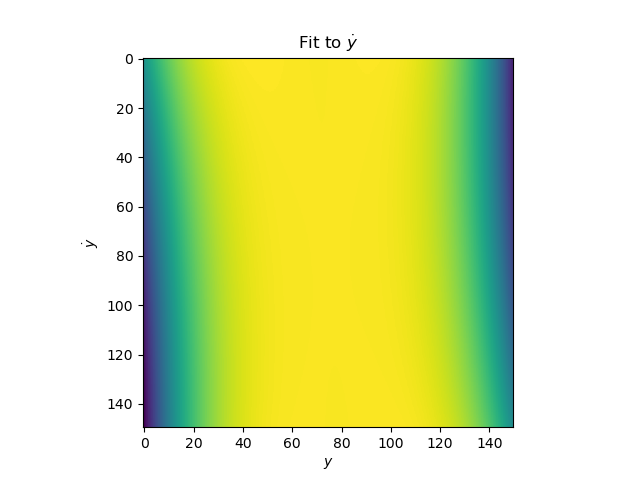

In [213]:
%matplotlib notebook
y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure()

ax_1 = fig.add_subplot(1, 1, 1)
r_1 = [[np.sum(o(el, sel)) for sel in ydot] for el in y]
ax_1.imshow(r_1)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')
plt.show()

<IPython.core.display.Javascript object>


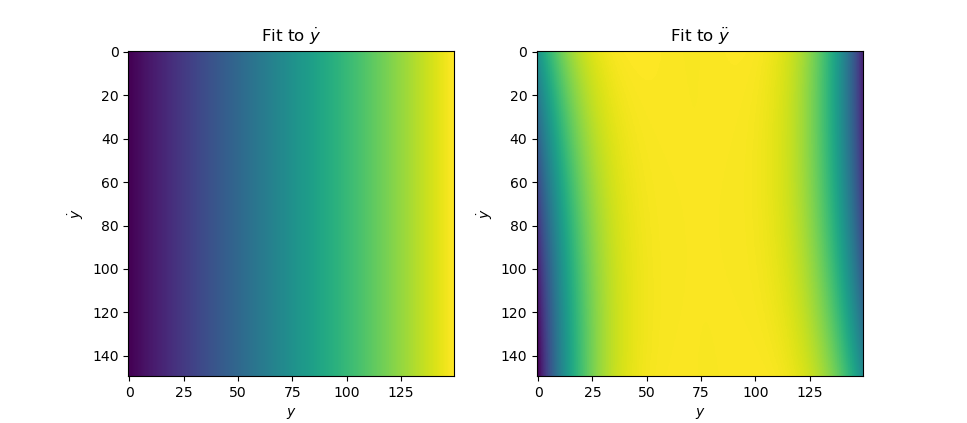

In [214]:
%matplotlib notebook
#f = lambda y, ydot, p: p[0] * y + p[1] * ydot + p[2] * y ** 2 + p[3] * y * ydot + p[4] * ydot ** 2 \
#                        + p[5] * y ** 3 + p[6] * y ** 2 * ydot + p[7] * y * ydot ** 2 + p[8] * ydot ** 3

y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure()

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = f(_, _, o_1)
r_1 = [[np.sum(r_1(el, sel)) for sel in ydot] for el in y]
ax_1.imshow(r_1)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = f(_, _, o_2)
r_2 = [[np.sum(r_2(el, sel)) for sel in ydot] for el in y]
ax_2.imshow(r_2)
ax_2.set_xlabel('$y$')
ax_2.set_ylabel('$\dot{y}$')
ax_2.set_title('Fit to $\ddot{y}$')

plt.show()

<IPython.core.display.Javascript object>


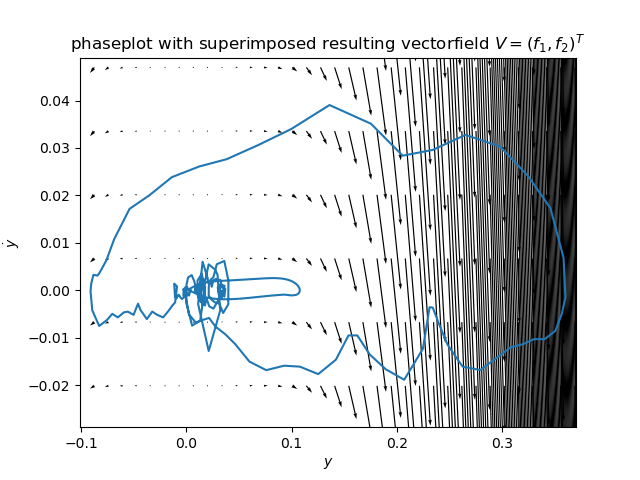

In [215]:
%matplotlib notebook
plt.plot(data_simulated['E1'], five_point_derivate_periodic(data_simulated['E1']))
plt.xlabel('$y$')
plt.ylabel('$\dot{y}$')
plt.title('phaseplot with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
plt.quiver(y, ydot, r_1, r_2, scale=10)
plt.xlim(np.min(data_simulated['E1']) - 0.01, np.max(data_simulated['E1']) + 0.01)
plt.ylim(np.min(five_point_derivate_periodic(data_simulated['E1'])) - 0.01, \
         np.max(five_point_derivate_periodic(data_simulated['E1'])) + 0.01)
plt.show()

If a vectorfield $V=(f_1,f_2)^T$ is drawn, the phaseplot of the time series should emerge from it. This is not true, see the figure above. This may be due to some wrong used statements or the low degree of the used polynom. Either way, I havent fully understood this problem yet.

## Doing this for all channels
The following plot shows the Fit to $\ddot{y}$ for all channels, simulated and measured.

In [9]:
header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

r_simulated = []
for el in header:
    if el == 'time': continue
    o = solve_eqs_for_p(data_simulated[el], \
                        five_point_derivate_periodic(data_simulated[el]), \
                        five_point_derivate_periodic(five_point_derivate_periodic(data_simulated[el])),
                        8) # [!] NOTE: no variable grade !
    r_simulated.append(o)

<IPython.core.display.Javascript object>


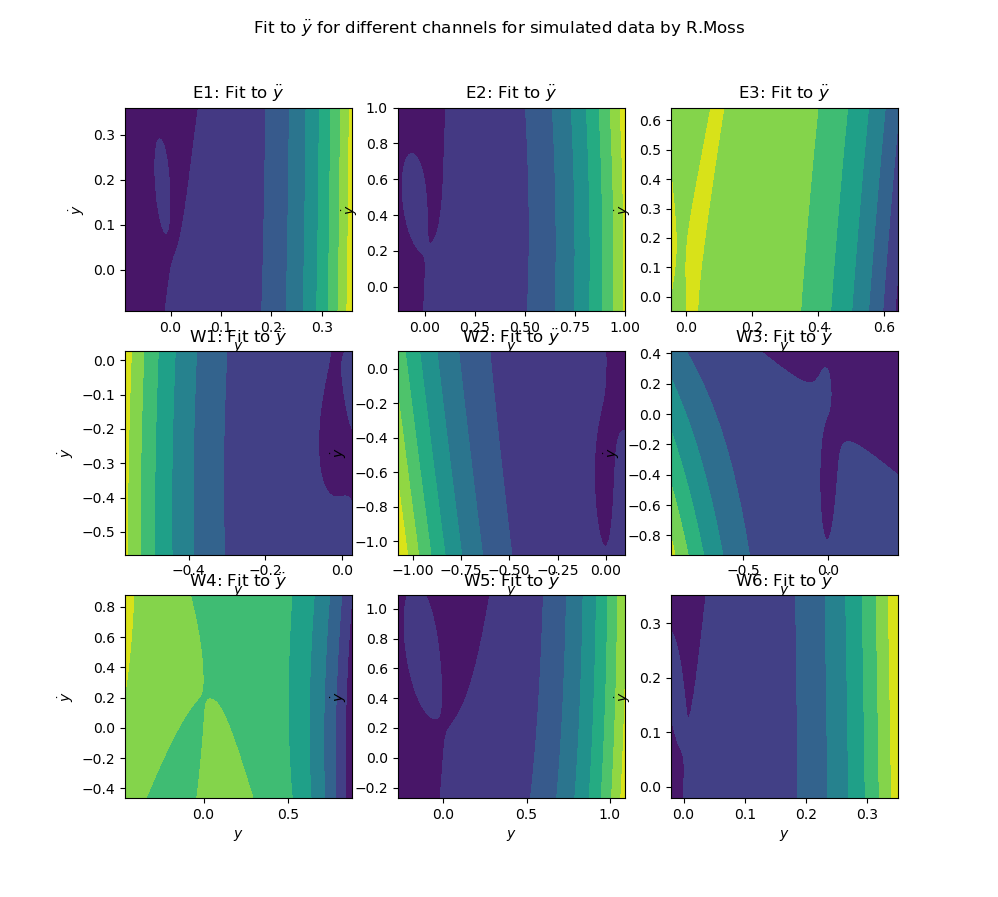

In [16]:
%matplotlib notebook
fig = plt.figure()

fig.suptitle('Fit to $\ddot{y}$ for different channels for simulated data by R.Moss')

for i in range(len(r_simulated)):   
    
    y = np.linspace(min(data_simulated[header[i + 1]]), max(data_simulated[header[i + 1]]), 100)
    ydot = y
    
    r_ = f(_, _, r_simulated[i])
    r_ = [[np.sum(r_(el, sel)) for sel in ydot] for el in y]
    
    ax = fig.add_subplot(3, 3, i + 1)
    ax.contourf(y, ydot, r_)
    
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\dot{y}$')
    ax.set_title('%s: Fit to $\ddot{y}$' % (header[i + 1]))

In [220]:
header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

r_measured = []
for el in header:
    if el == 'time': continue
    o = solve_eqs_for_p_variable_grade(data_measured[el], \
                        five_point_derivate_periodic(data_measured[el]), \
                        five_point_derivate_periodic(five_point_derivate_periodic(data_measured[el])),
                        8)
    r_measured.append(o)

<IPython.core.display.Javascript object>


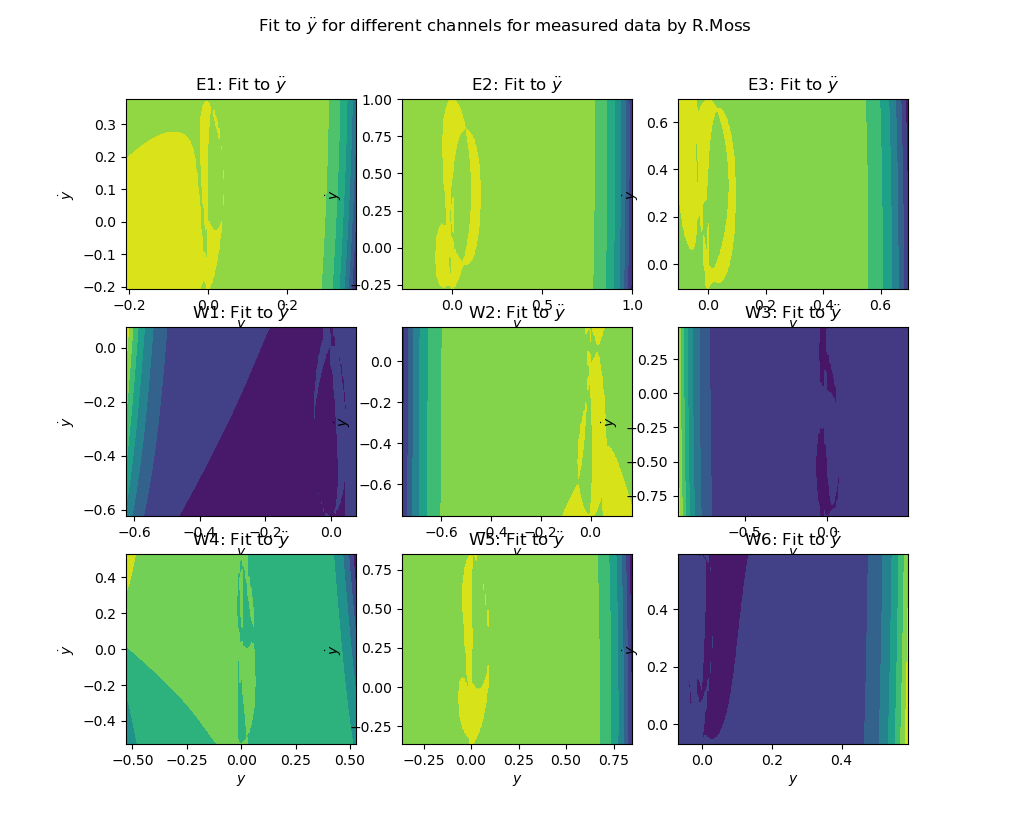

In [221]:
%matplotlib notebook
fig = plt.figure()

fig.suptitle('Fit to $\ddot{y}$ for different channels for measured data by R.Moss')

for i in range(len(r_measured)):   
    
    y = np.linspace(min(data_measured[header[i + 1]]), max(data_measured[header[i + 1]]), 100)
    ydot = y
    
    r_ = f(_, _, r_measured[i])
    r_ = [[np.sum(r_(el, sel)) for sel in ydot] for el in y]
    
    ax = fig.add_subplot(3, 3, i + 1)
    ax.contourf(y, ydot, r_)
    
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\dot{y}$')
    ax.set_title('%s: Fit to $\ddot{y}$' % (header[i + 1]))

In the following plot the absolute difference between the fit of $\ddot{y}$ to simulated and measured data is shown. The greatest differences are noticable towards the edges, in particular the "right" ($y->y_{max}$) for channels $E1...E3$ and to the "left" edges ($y->y_{min}$) for channels $W1...W3$, where $y_{max}$ represents the maximal value for the channels time series $y$ and analog $y_{min}$ for the smallest.
<!-- These deviations can be explained with the naturally increasing values of $f_2$ for greater values. The same effect is liable for deviations in $W4, W5$. -->

<IPython.core.display.Javascript object>


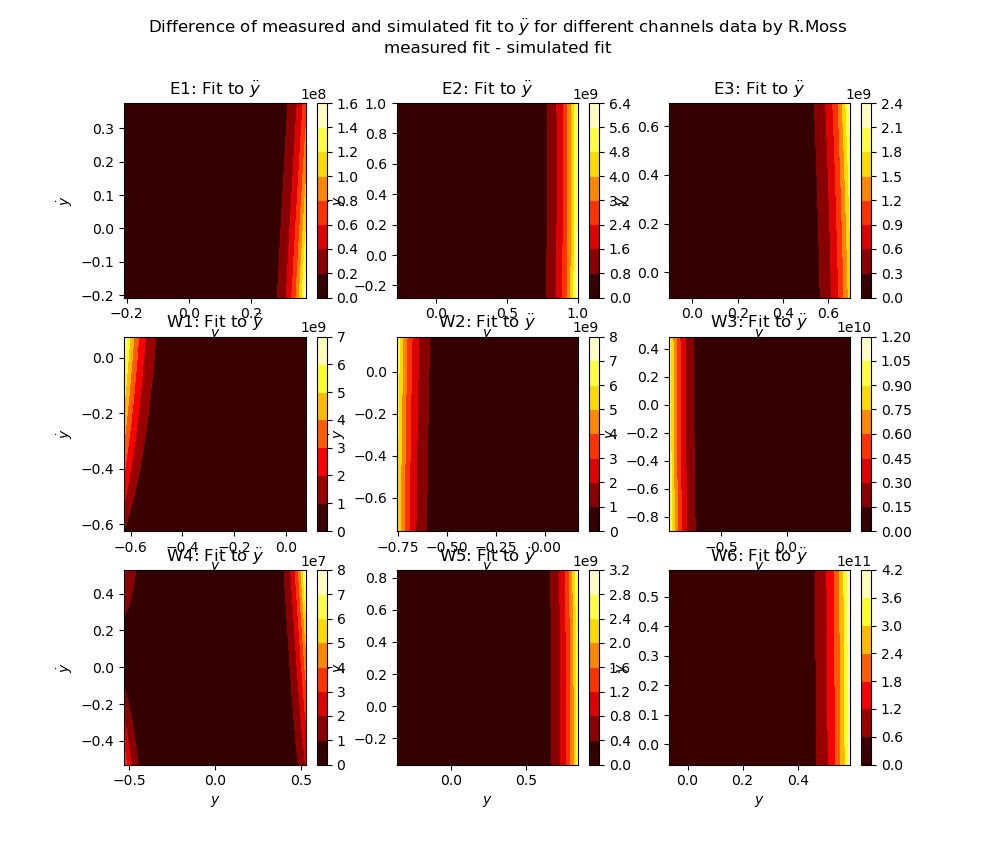

In [222]:
%matplotlib notebook
fig = plt.figure()

fig.suptitle('Difference of measured and simulated fit to $\ddot{y}$ for different channels data by R.Moss\n' \
             + 'measured fit - simulated fit')

for i in range(len(r_measured)):   
    
    y = np.linspace(min(data_measured[header[i + 1]]), max(data_measured[header[i + 1]]), 100)
    ydot = y
    
    r_ = f(_, _, r_measured[i])
    r__ = f(_, _, r_simulated[i])
    r_ = [[np.abs(np.sum(r_(el, sel)) - np.sum(r__(el, sel))) for sel in ydot] for el in y]
    
    ax = fig.add_subplot(3, 3, i + 1)
    d = ax.contourf(y, ydot, r_, cmap='hot')
    fig.colorbar(d)
    
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\dot{y}$')
    ax.set_title('%s: Fit to $\ddot{y}$' % (header[i + 1]))

For now, only the second component, $f_2$ was shown. For the purpose of verification, function $f_1$ is written here. Remember that we expect $f_1$ to be linear for all channels.

In [147]:
header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

r = []
for el in header:
    if el == 'time': continue
    o = solve_eqs_for_p(data_simulated[el], \
                        five_point_derivate_periodic(data_simulated[el]), \
                        five_point_derivate_periodic(data_simulated[el]))
    r.append([header[i] + ' simulated', o])
    o = solve_eqs_for_p(data_measured[el], \
                        five_point_derivate_periodic(data_measured[el]), \
                        five_point_derivate_periodic(data_measured[el]))
    r.append([header[i] + ' measured', o])

In [150]:
for el in r:
    print(el[0] + ': ')
    print_function(el[1])

W5 simulated: 
0.000000 * y + 1.000000 * ydot + 0.000000 * y ** 2 + -0.000000 * y * ydot + -0.000000 * ydot ** 2
W5 measured: 
-0.000000 * y + 1.000000 * ydot + -0.000000 * y ** 2 + 0.000000 * y * ydot + 0.000000 * ydot ** 2
W5 simulated: 
-0.000000 * y + 1.000000 * ydot + -0.000000 * y ** 2 + 0.000000 * y * ydot + 0.000000 * ydot ** 2
W5 measured: 
0.000000 * y + 1.000000 * ydot + -0.000000 * y ** 2 + -0.000000 * y * ydot + -0.000000 * ydot ** 2
W5 simulated: 
-0.000000 * y + 1.000000 * ydot + 0.000000 * y ** 2 + -0.000000 * y * ydot + -0.000000 * ydot ** 2
W5 measured: 
0.000000 * y + 1.000000 * ydot + -0.000000 * y ** 2 + 0.000000 * y * ydot + 0.000000 * ydot ** 2
W5 simulated: 
0.000000 * y + 1.000000 * ydot + 0.000000 * y ** 2 + -0.000000 * y * ydot + 0.000000 * ydot ** 2
W5 measured: 
0.000000 * y + 1.000000 * ydot + 0.000000 * y ** 2 + 0.000000 * y * ydot + -0.000000 * ydot ** 2
W5 simulated: 
0.000000 * y + 1.000000 * ydot + 0.000000 * y ** 2 + 0.000000 * y * ydot + -0.000000 *

Notice that $p_0=p_2=p_3=p_4=0$ but $p_1=1$ for all channels, resulting in a linear $f_1$. Basically the initial ansatz can now be written as:

$$
\dot{y} = y\\
\ddot{y} = f_2(y, \dot{y})
$$

## Solving resulting differential equations
Firstly for channel $E1$ simulated solving its ODE whose equation equals the above one.

In [18]:
from scipy.integrate import solve_ivp

In [19]:
def func(t, x, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]
    
    y[0] = x[1]
    y[1] = fit_to_ydot(x[0], x[1])
    return y

In [31]:
T = 500

# get ode solution for any channel simulated
res = []
for index in [1,2,3]:
    data = r_simulated[index - 1]
    ivp = [0, 0]
    ivp[0] += data_simulated[header[index]][0]
    ivp[1] += five_point_derivate_periodic(data_simulated[header[index]])[0]

    sol = solve_ivp(func, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[f(_, _, data)])

    t = np.linspace(0, T, T)
    y, ydot = sol.sol(t)
    
    res.append((t, y, ydot))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


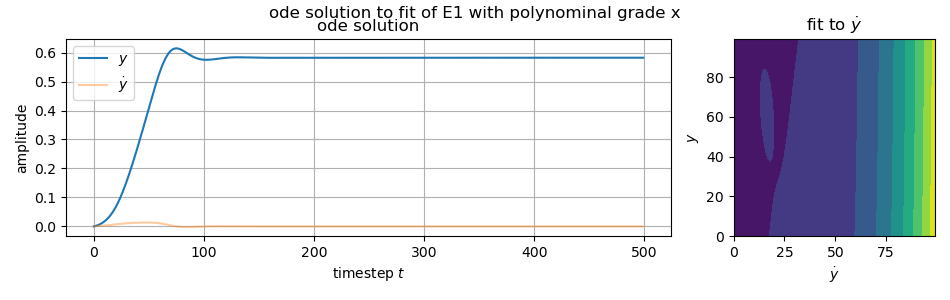

In [30]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

max_index = -1
a0.plot(res[0][0][:max_index], res[0][1][:max_index], label='$y$')
a0.plot(res[0][0][:max_index], res[0][2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(data_simulated[header[1]]), max(data_simulated[header[1]]), 100)
ydot_ = y_
r_ = f(_, _, r_simulated[0])
r_ = [[np.sum(r_(el, sel)) for sel in ydot_] for el in y_]
a1.contourf(r_)
a1.set_title('fit to $\dot{y}$')
a1.set_xlabel('$\dot{y}$')
a1.set_ylabel('$y$')

fig.suptitle('ode solution to fit of E1 with polynominal grade x')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


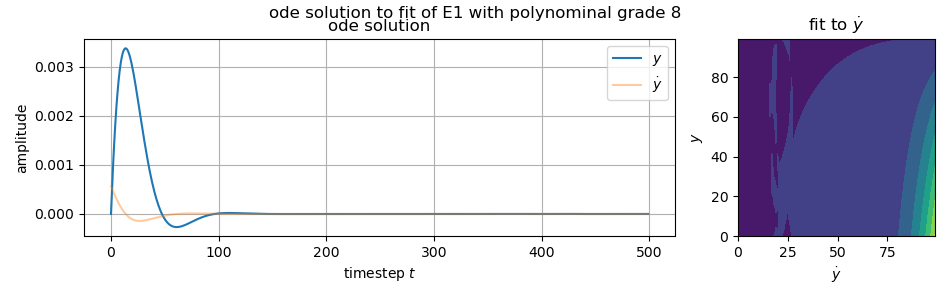

<IPython.core.display.Javascript object>


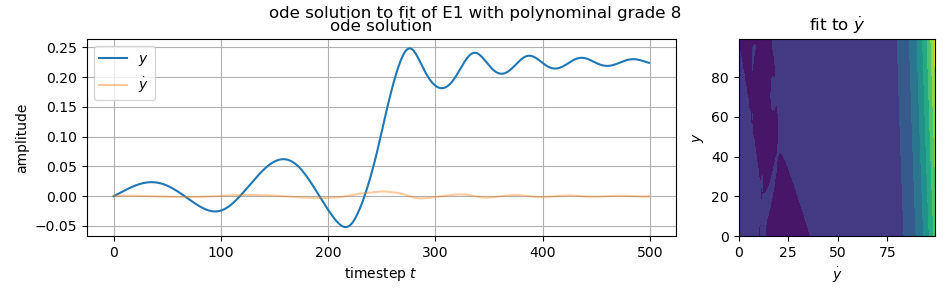

<IPython.core.display.Javascript object>


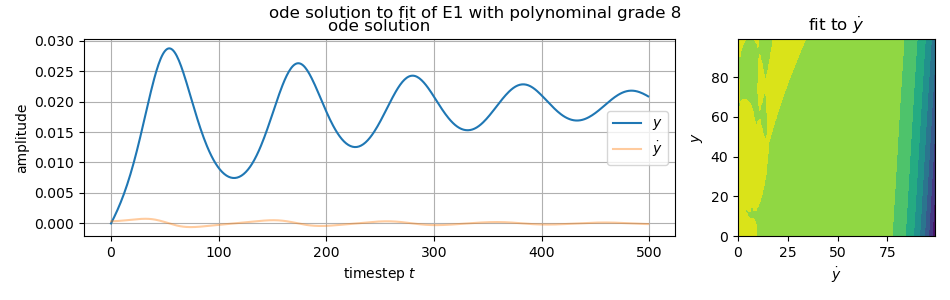

<IPython.core.display.Javascript object>


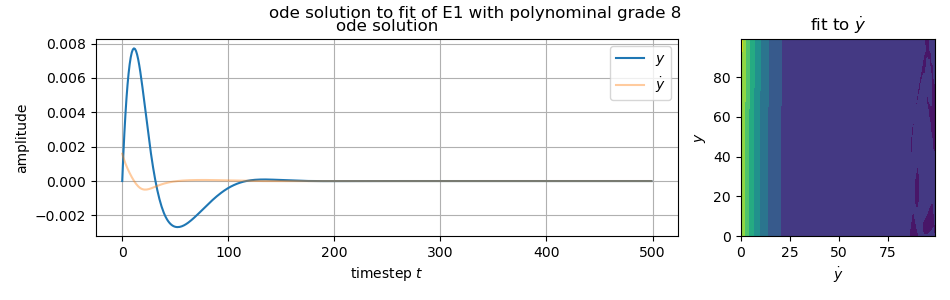

<IPython.core.display.Javascript object>


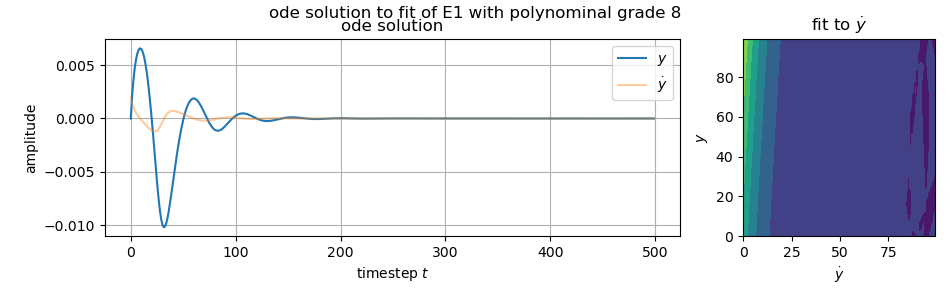

In [249]:
%matplotlib notebook

for i in range(len(res)):
    fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

    max_index = -1
    t = res[i][0]
    y = res[i][1]
    ydot = res[i][2]
    
    a0.plot(t[:max_index], y[:max_index], label='$y$')
    a0.plot(t[:max_index], ydot[:max_index], label='$\dot{y}$', alpha=0.4)
    a0.set_xlabel('timestep $t$')
    a0.set_ylabel('amplitude')
    a0.grid()
    a0.legend()
    a0.set_title('ode solution')

    y_ = np.linspace(min(data_simulated[header[i + 1]]), max(data_simulated[header[i + 1]]), 100)
    ydot_ = y_
    r_ = f(_, _, r_simulated[i])
    r_ = [[np.sum(r_(el, sel)) for sel in ydot_] for el in y_]
    a1.contourf(r_)
    a1.set_title('fit to $\dot{y}$')
    a1.set_xlabel('$\dot{y}$')
    a1.set_ylabel('$y$')

    fig.suptitle('ode solution to fit of E1 with polynominal grade 8')

    plt.tight_layout()
    plt.show()